# Модель предсказания оттока клиентов для оператора связи «Ниединогоразрыва.ком»

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг


Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Описание данных:
- contract_new.csv - информация о договоре
    - customerID - уникальный ID клиента
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами
    - Type - тип договора: ежемесячный, годовой и т.д
    - PaperlessBilling - выставления счёта по электронной почте
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги
- personal_new.csv - персональные данные клиента
    - customerID - уникальный ID клиента
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга/супруги
    - Dependents - наличие иждивенцев
- internet_new.csv - информация об интернет-услугах
    - customerID - уникальный ID клиента
    - InternetService - наличие услуг Интернет
    - OnlineSecurity - межсетевой экран
    - OnlineBackup - облачное хранилище файлов для резервного копирования данных
    - DeviceProtection - антивирус
    - TechSupport - выделенная линия технической поддержки
    - StreamingTV - онлайн-ТВ
    - StreamingMovies - онлайн-кинотеатр
- phone_new.csv - информация об услугах телефонии
    - customerID - уникальный ID клиента
    - MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно

## Цель исследования 

Необходимо предсказать уход клиента - отказ от продолжения пользования услугами, предоставляемыми заказчиком.

Эта задача относится к бинарной классификации, где необходимо определить, принадлежит ли объект к одному из двух классов - ушел ли клиент (1) или нет (0). 

# План исследования

1. Загрузка данных и изучение общей информации.
2. Объединение данных из всех файлов в один датафрейм.
3. Выделение целевого признака.
4. Предобработка данных и исследовательский анализ: 
- Заменить названия столбцов (привести к нижнему регистру) при необходимости.
- Преобразовать данные в нужные типы. Описать в каких столбцах заменили тип данных.
- Обработать пропуски при необходимости.
- Избавиться от аномалий, дубликатов при необходимости.
- Исследование баланса классов и распределение признаков в разрезе целевой переменной.
- Анализ признаков на мультиколлинеарность.
5. Подготовка данных к обучению:
- Отбор наиболее важных признаков для прогнозирования оттока клиентов. Добавление новых признаков при необходимости.
- Разбиение данных на обучающую и тестовую выборки.
- Кодирование данных (с учетом используемых моделей).
- Масштабирование при необходимости.
6. Обучение и контроль качества модели машинного обучения:
- Обучение разных моделей, подбор гиперпараметров и оценка качества моделей кросс-валидацией (основная метрика ROC-AUC, дополнительная метрика для интерпретации (с матрицей ошибок) - accuracy). 
- Отбор лучшей модели и проверка её на тестовой выборке (значение ROC-AUC>=0.85 на тестовой выборке, построение и описание ROC-кривой). Анализ важности признаков лучшей модели.
- Описание выводов.
7. Анализ результатов и общий вывод.

# 1. Загрузка данных и изучение общей информации
Установим и импортируем необходимые библиотеки.

In [1]:
! pip install phik

     |████████████████████████████████| 679 kB 1.0 MB/s eta 0:00:01


In [2]:
! pip install lightgbm

In [3]:
! pip install shap

     |████████████████████████████████| 547 kB 1.0 MB/s eta 0:00:01


In [4]:
import time
import warnings

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import tqdm.auto
import seaborn as sns
from lightgbm import LGBMClassifier
from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score,
    confusion_matrix, precision_recall_curve, precision_score,
    recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 28082023

Прочитаем данные

In [5]:
try:
    df_contract = pd.read_csv('contract_new.csv')
    df_personal = pd.read_csv('personal_new.csv')
    df_internet = pd.read_csv('internet_new.csv')
    df_phone = pd.read_csv('phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

Напишем функцию, которая принимает на вход датафрейм и выводит все необходимые характеристики

In [6]:
def analysis(df):
    print('Вывод первых 5 строк данных')
    display(df.head())
    print()
    print('Общая информация о датафрейме')
    df.info()
    print()
    print('Получение базовых статистик')
    display(df.describe())
    print()
    print('Подсчет пропусков')
    print()
    print(df.isnull().sum())
    print()
    print('Подсчет дубликатов')
    print(df.duplicated().sum())
    print()
    print('Информация об уникальных значениях в столбцах')
    print()
    for column in df.columns:
        print(f' Столбец {column} - Количество уникальных значений: {df[column].nunique()}')
        print(f'Уникальные значения {column}: {df[column].unique()}')
        print()   

Рассмотрим первый датасет df_contract - информация о договоре

In [7]:
analysis(df_contract)

Вывод первых 5 строк данных


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Получение базовых статистик


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Подсчет пропусков

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Подсчет дубликатов
0

Информация об уникальных значениях в столбцах

 Столбец customerID - Количество уникальных значений: 7043
Уникальные значения customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 Столбец BeginDate - Количество уникальных значений: 77
Уникальные значения BeginDate: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11

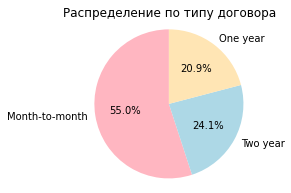

In [8]:
type_counts = df_contract['Type'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6', '#FFE5B4']
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение по типу договора')
plt.show()

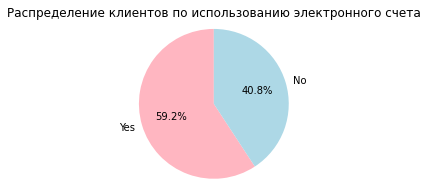

In [9]:
billing_counts = df_contract['PaperlessBilling'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6', '#FFE5B4']
plt.pie(billing_counts.values, labels=billing_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по использованию электронного счета')
plt.show()

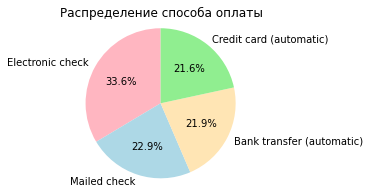

In [10]:
payment_counts = df_contract['PaymentMethod'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6', '#FFE5B4', '#90EE90']
plt.pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение способа оплаты')
plt.show()

Выводы по графикам:
- По типу договора лидирует ежемесячный контракт (55%). Клиентов, которые оплачивают контракт на год и на два года значительно меньше(20,9%), при этом заключают договор на 2 года (24,1%) чаще, чем на год, скорее всего из-за скидок и более лояльных условий.
- Большинство клиентов предпочитают получать электронный счет по почте (59,2%).
- Популярный способ оплаты счета - с помощью электронного чека (33,6%), остальные способы оплаты (отправленный по почте чек, банковский перевод и оплат с помощью кредитной карты) находятся примерно на одном уровне в районе 21-23%.

- В таблице 8 столбцов и 7043 строк. 
- Названия столбцов необходимо записать в «змеином регистре».
- Пропусков и явных дубликатов в данных нет.
- Типы данных float64(1), object(7), при этом в столбцах есть некорректный тип данных. BeginDate и EndDate необходимо перевести в формат даты, а TotalCharges - в числовой тип float64.
- EndDate (дата окончания пользования услугами) - целевая переменная. "No" означает, что клиент пользуется услугами, если клиент ушел - в строке стоит дата окончания. 
- Целевой признак нужно будет выделить в отдельный столбец на основе данных о контракте - 1 (ушел) и 0 (не ушел). Информация о договорах актуальна на 1 февраля 2020 года, следовательно, после выделения целевого признака вместо "No" в столбце EndDate заменим всё на дату 2020-02-01.
- Признаки перед передачей в модель необходимо будет закодировать.
- Клиенты чаще выбирают тип договора - ежемесячный (55%). 
- Большинство клиентов предпочитают получать электронный счет по почте (59,2%) и оплачивать его с помощью электронного чека (33,6%).


Рассмотрим датасет df_personal - персональные данные клиента

In [11]:
analysis(df_personal)

Вывод первых 5 строк данных


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Получение базовых статистик


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Подсчет пропусков

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Подсчет дубликатов
0

Информация об уникальных значениях в столбцах

 Столбец customerID - Количество уникальных значений: 7043
Уникальные значения customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 Столбец gender - Количество уникальных значений: 2
Уникальные значения gender: ['Female' 'Male']

 Столбец SeniorCitizen - Количество уникальных значений: 2
Уникальные значения SeniorCitizen: [0 1]

 Столбец Partner - Количество уникальных значений: 2
Уникальные значения Partner: ['Yes' 'No']

 Столбец Dependents - Количество уникальных значений: 2
Уникальные значения Dependents: ['No' 'Yes']



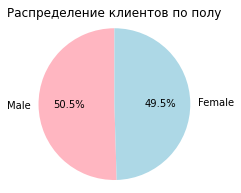

In [12]:
gender_counts = df_personal['gender'].value_counts()
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по полу')
plt.show()

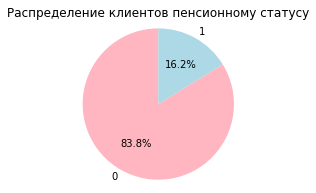

In [13]:
senior_counts = df_personal['SeniorCitizen'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(senior_counts.values, labels=senior_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов пенсионному статусу')
plt.show()

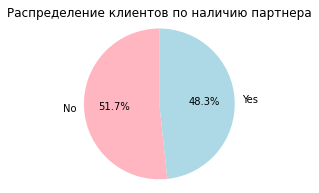

In [14]:
partner_counts = df_personal['Partner'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(partner_counts.values, labels=partner_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по наличию партнера')
plt.show()

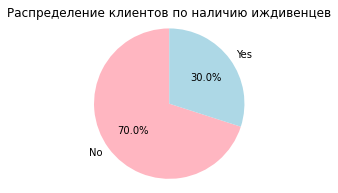

In [15]:
dependents_counts = df_personal['Dependents'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(dependents_counts.values, labels=dependents_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по наличию иждивенцев')
plt.show()

- В таблице 5 столбцов и 7043 строк. 
- Названия столбцов необходимо записать в «змеином регистре».
- Пропусков и явных дубликатов в данных нет.
- Типы данных int64(1), object(4).
- Признаки перед передачей в модель необходимо будет закодировать.
- Распределение клиентов по полу практически одинаковое - male (50,5%), female(49,5%).
- Клиентов в пожилом возрасте очень мало (16,2%). 
- Холостых клиентов чуть больше (51,7%), чем клиентов с партнерами(супругом/супругой) - 48,3%.
- Клиентов с иждивенцеми значительно меньше (70%), чем с их наличием (30%).

Рассмотрим датасет df_internet - информация об интернет-услугах

In [16]:
analysis(df_internet)

Вывод первых 5 строк данных


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Получение базовых статистик


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2186-QZEYA,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Подсчет пропусков

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Подсчет дубликатов
0

Информация об уникальных значениях в столбцах

 Столбец customerID - Количество уникальных значений: 5517
Уникальные значения customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 Столбец InternetService - Количество уникальных значений: 2
Уникальные значения InternetService: ['DSL' 'Fiber optic']

 Столбец OnlineSecurity - Количество уникальных значений: 2
Уникальные значения OnlineSecurity: ['No' 'Yes']

 Столбец OnlineBackup - Количество уникальных значений: 2
Уникальные значения OnlineBackup: ['Yes' 'No']

 Столбец DeviceProtection - Количество уникальных значений: 2
Уникальные значения DeviceProtection: ['No' 'Yes']

 Столбец TechSupport - Количество уникальных значений: 2
Уникальные значения TechSupport: ['N

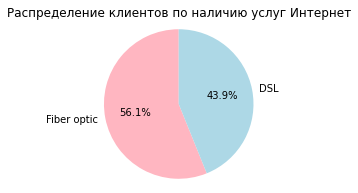

In [17]:
internet_counts = df_internet['InternetService'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(internet_counts.values, labels=internet_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по наличию услуг Интернет')
plt.show()

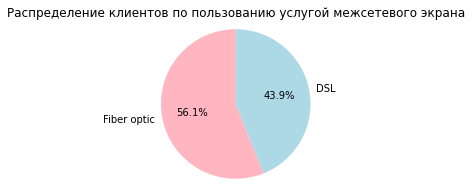

In [18]:
security_counts = df_internet['OnlineSecurity'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(internet_counts.values, labels=internet_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой межсетевого экрана')
plt.show()

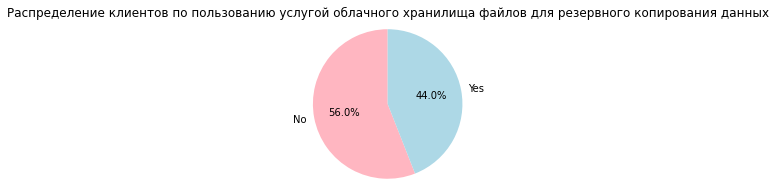

In [19]:
backup_counts = df_internet['OnlineBackup'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(backup_counts.values, labels=backup_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой облачного хранилища файлов для резервного копирования данных')
plt.show()

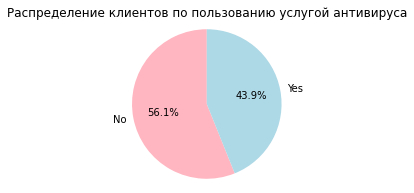

In [20]:
protection_counts = df_internet['DeviceProtection'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(protection_counts.values, labels=protection_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой антивируса')
plt.show()

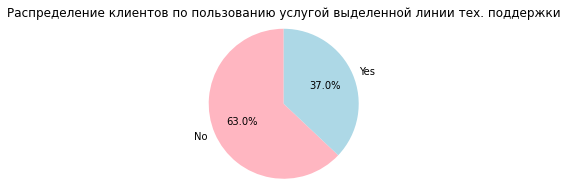

In [21]:
support_counts = df_internet['TechSupport'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(support_counts.values, labels=support_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой выделенной линии тех. поддержки')
plt.show()

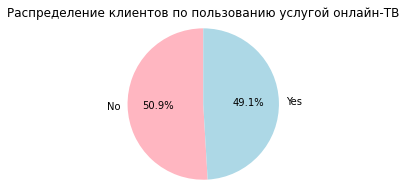

In [22]:
tv_counts = df_internet['StreamingTV'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(tv_counts.values, labels=tv_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой онлайн-ТВ')
plt.show()

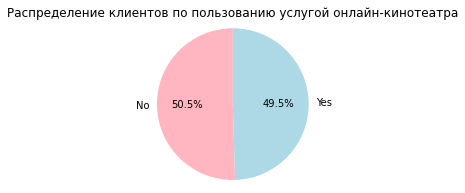

In [23]:
movies_counts = df_internet['StreamingMovies'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(movies_counts.values, labels=movies_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по пользованию услугой онлайн-кинотеатра')
plt.show()

- В таблице 8 столбцов и 5517 строк. 
- Названия столбцов необходимо записать в «змеином регистре».
- Пропусков и явных дубликатов в данных нет.
- Типы данных object(8).
- Признаки перед передачей в модель необходимо будет закодировать.
- По подключению услуги Интернет лидирует оптоволоконный кабель(56,1%).
- Распределение клиентов по пользованию услугами: межсетевого экрана, облачного хранилищя файлов для резервного копирования данных, антивирус, выделенной линии технической поддержки -  показывает, что люди чаще отказываются от дополнительных услуг.
- Распределение клиентов по наличию услуг онлайн-кинотеатра(50,5%) и онлайн-ТВ практически одинаково(49,5%).

Рассмотрим датасет df_phone - информация об услугах телефонии

In [24]:
analysis(df_phone)

Вывод первых 5 строк данных


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Получение базовых статистик


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2186-QZEYA,No
freq,1,3390



Подсчет пропусков

customerID       0
MultipleLines    0
dtype: int64

Подсчет дубликатов
0

Информация об уникальных значениях в столбцах

 Столбец customerID - Количество уникальных значений: 6361
Уникальные значения customerID: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

 Столбец MultipleLines - Количество уникальных значений: 2
Уникальные значения MultipleLines: ['No' 'Yes']



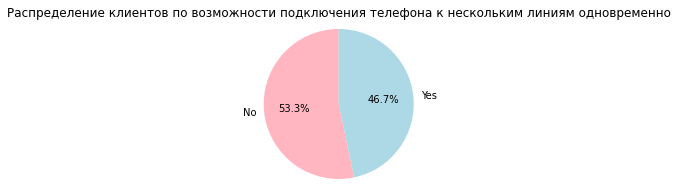

In [25]:
lines_counts = df_phone['MultipleLines'].value_counts(normalize=True) * 100
plt.figure(figsize=(3, 3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(lines_counts.values, labels=lines_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение клиентов по возможности подключения телефона к нескольким линиям одновременно')
plt.show()

- В таблице 2 столбца и 6361 строк. 
- Названия столбцов необходимо записать в «змеином регистре».
- Пропусков и явных дубликатов в данных нет.
- Признак перед передачей в модель необходимо будет закодировать.
- На распределении клиентов по услуге возможности подключения телефона к нескольким линиям одновременно перевес в сторону тех, кто ее не использует (53,3%)

**Вывод:**

Мы провели первичный анализ 4-х датасетов. Таблицы разного размера. 

В данных отсутствуют пропуски и явные дубликаты, но есть некорректный тип данных в некоторых столбцах. Необходимо будет преобразовать категориальные переменные в числовые значения и бинарные признаки в (0, 1).

Целевой признак - дата окончания пользования услугами. Его необходимо выделить в отдельный столбец на основе данных о контракте - 1 (ушел) и 0 (не ушел). Информация о договорах актуальна на 1 февраля 2020 года, следовательно, после выделения целевого признака вместо "No" в столбце EndDate заменим всё на дату 01-02-2020. 

Признаки перед передачей в модель необходимо будет закодировать.

Клиенты чаще выбирают тип договора - ежемесячный (55%), так же предпочитают получать электронный счет по почте (59,2%) и оплачивать его с помощью электронного чека (33,6%). 

В данных клиенты по полу распределены практически равномерно - male (50,5%) и female(49,5%), Холостых клиентов чуть больше (51,7%), чем с партнерами(супругом/супругой) - 48,3%. Пожилые люди практически не пользуются услугами интернета и телефонной связи (16,2%). Клиентов с иждивенцеми значительно меньше (70%), чем с их наличием (30%).

По подключению услуги Интернет лидирует оптоволоконный кабель(56,1%).

От дополнительных услуг пользователи чаще отказываются, а услугами онлайн-кинотеатра(50,5%) и онлайн-ТВ (49,5%) клиенты пользуются практически одинаково.

По услуге возможности подключения телефона к нескольким линиям одновременно перевес в сторону тех, кто ее не использует (53,3%).


# 2. Объединение данных из всех файлов в один датафрейм.

Объедим все таблиц по столбцу customerID, используя метод set_index для установки этого столбца в качестве индекса. Результатом будет новая таблица, содержащая данные из всех исходных таблиц, объединенных по столбцу customerID.

In [26]:
df = df_contract \
    .join(df_personal.set_index('customerID'), on='customerID') \
    .join(df_internet.set_index('customerID'), on='customerID') \
    .join(df_phone.set_index('customerID'), on='customerID')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


# 3. Выделение целевого признака

Выделим целевой признак в отдельный столбец - Exited на основе данных о контракте:
- если в столбце EndDate стоит дата ухода, то целевой признак равен 1 (ушел) 
- если в столбце EndDate стоит значение - "No", то значит клиент не ушел и целевой признак равен 0 (не ушел). 

In [28]:
df['Exited'] = (df['EndDate'] != 'No').astype(int)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


# 4. Предобработка данных и исследовательский анализ

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Переименуем названия столбцов, приведем "змеиному стилю"

In [30]:
for i, s in enumerate(df.columns):
    s = ''.join(['_' + c.lower() if (c.isupper() and i!=0) else c for i,c in enumerate(s)]).lstrip('_')
    s = s.replace('_i_d', '_id').replace('_t_v', '_tv')
    df = df.rename(columns={df.columns[i]: s})

Приведем все столбцы к нижнему регистру 

In [31]:
df.columns = df.columns.str.lower() 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

В датасете есть некорректный тип данных в некоторых столбцах. begin_date и end_date необходимо перевести в формат даты, а total_charges - в числовой тип float64.

In [33]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

Информация о договорах актуальна на 1 февраля 2020 года, следовательно, вместо "No" в столбце end_date заменим всё на дату 01-02-2020.

In [34]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [35]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

В признаке senior_citizen изменим тип с числового на object. 

In [36]:
df['senior_citizen'] = df['senior_citizen'].replace({1: 'yes', 0: 'no'})

In [37]:
df.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
gender                       object
senior_citizen               object
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiple_lines               object
exited                        int64
dtype: object

In [38]:
df.isna().sum() # подсчёт пропусков

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
exited                  0
dtype: int64

Приступим к обработке пропущенных значений. 

Рассмотрим столбец total_charges - всего потрачено денег на услуги.

In [39]:
df[df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,no,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,no,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,no,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,no,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,no,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,no,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,no,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,no,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,no,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,no,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Это новые клиенты, так как дата в столбце end_date - 2020-02-01, отсюда и пропуски - отсутствуют платежи по услугам. Заполним пропуски в total_charges на значения monthly_charges.

In [40]:
df['total_charges'].fillna(df[df['total_charges'].isna()]['monthly_charges'], inplace = True)

Рассмотрим столбец internet_service -  наличие услуг интернет. 

Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic), если клиент не пользуется услугами интернета, то пропуски можно заполнить значением unused. 

Соответственно, если весь пакет интернета не подключен, то дополнительные услуги тоже будут не подключены, поэтому пропуски в  столбцах можно  online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies можно заполнить тем же значением.

In [41]:
# список столбцов для заполнения
cols_to_fill = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 
                'streaming_tv', 'streaming_movies']
# заполнение пропущенных значений 
for col in cols_to_fill:
    df[col].fillna('unused', inplace=True)

В столбце multiple_lines - возможность подключения телефонного аппарата к нескольким линиям одновременно пропуски заполним аналогично.

In [42]:
df['multiple_lines'].fillna('unused', inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Посмотрим на распределение классов в  exited - целевой переменной. 1 (ушел) и 0 (не ушел).

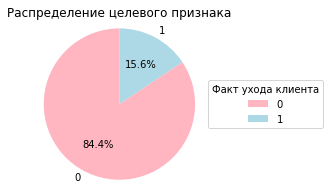

In [44]:
exited_counts = df['exited'].value_counts(normalize=True) * 100
plt.figure(figsize=(3,3))
colors = ['#FFB6C1', '#ADD8E6']
plt.pie(exited_counts.values, labels=exited_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Распределение целевого признака')
plt.legend(title='Факт ухода клиента', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Клиентов, которые прекратили пользоваться услугами намного меньше, чем тех, кто пользуется.

Выделим в отдельный столбец период пользования услугами клиентами в днях.


In [45]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [46]:
df['duration'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64

Средняя продолжительность пользования услугами примерно 2,5 года. Максимальный период пользования услугами - почти 6,5 лет.

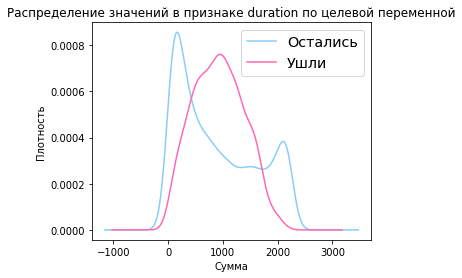

In [47]:
plt.figure(figsize=(5, 4))
df[df['exited'] == 0]['duration'].plot(kind='kde', color='#87CEFA', label='Остались')
df[df['exited'] == 1]['duration'].plot(kind='kde', color='#FF69B4', label='Ушли')
plt.title('Распределение значений в признаке duration по целевой переменной')
plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Посмотрим распределение значений для количественных данных

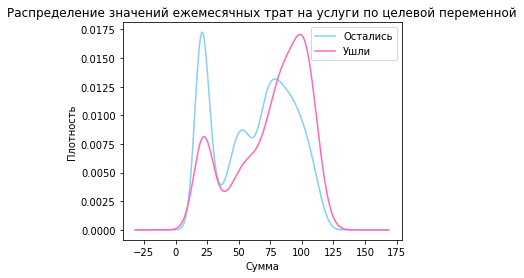

In [48]:
plt.figure(figsize=(5, 4))
df[df['exited'] == 0]['monthly_charges'].plot(kind='kde', color='#87CEFA', label='Остались')
df[df['exited'] == 1]['monthly_charges'].plot(kind='kde', color='#FF69B4', label='Ушли')
plt.title('Распределение значений ежемесячных трат на услуги по целевой переменной')
plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

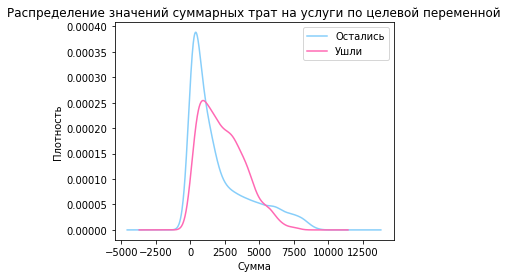

In [49]:
plt.figure(figsize=(5, 4))
df[df['exited'] == 0]['total_charges'].plot(kind='kde', color='#87CEFA', label='Остались')
df[df['exited'] == 1]['total_charges'].plot(kind='kde', color='#FF69B4', label='Ушли')
plt.title('Распределение значений суммарных трат на услуги по целевой переменной')
plt.xlabel('Сумма')
plt.ylabel('Плотность')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

Суммарные траты на услуги - total_charges больше у оставшихся клиентов, то есть чем выше общие траты, тем дольше клиент остается. В monthly_charges есть пик минимальной цены - наиболее популярна абонентская плата с наименьшей стоимостью, если расходы трат на ежемесячные услуги высокие - клиенты надолго не остаются.

Посмотрим на распределения категориальных признаков по факту ухода клиента. 

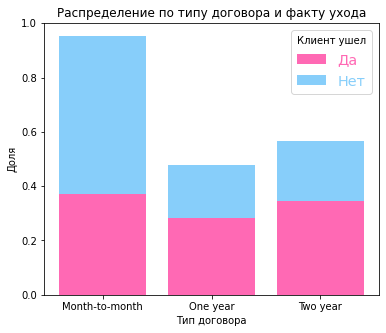

In [50]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('type').size().reset_index(name='count')
stayed_counts = stayed.groupby('type').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(6,5))
plt.bar(left_counts['type'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['type'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по типу договора и факту ухода')
plt.xlabel('Тип договора')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

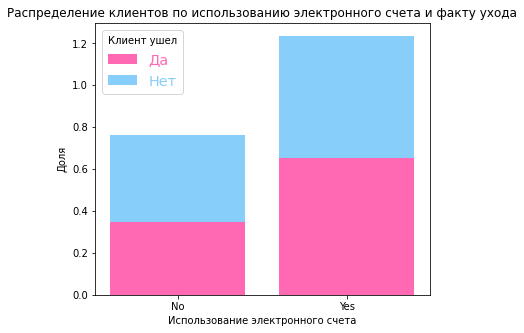

In [51]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('paperless_billing').size().reset_index(name='count')
stayed_counts = stayed.groupby('paperless_billing').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(6,5))
plt.bar(left_counts['paperless_billing'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['paperless_billing'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение клиентов по использованию электронного счета и факту ухода')
plt.xlabel('Использование электронного счета')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper left', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

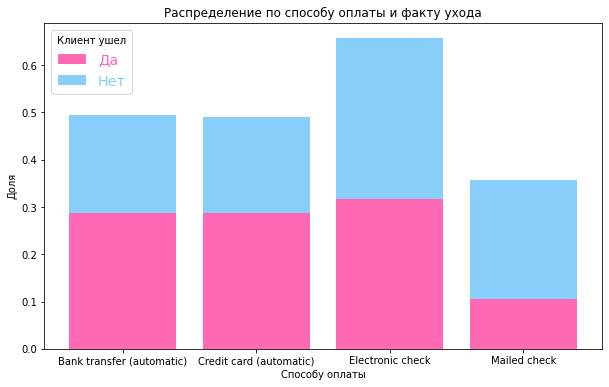

In [52]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('payment_method').size().reset_index(name='count')
stayed_counts = stayed.groupby('payment_method').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(10,6))
plt.bar(left_counts['payment_method'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['payment_method'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по способу оплаты и факту ухода')
plt.xlabel('Способу оплаты')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper left', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

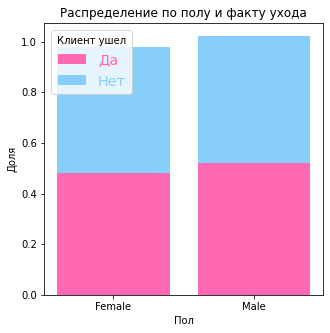

In [53]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('gender').size().reset_index(name='count')
stayed_counts = stayed.groupby('gender').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,5))
plt.bar(left_counts['gender'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['gender'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по полу и факту ухода')
plt.xlabel('Пол')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper left', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

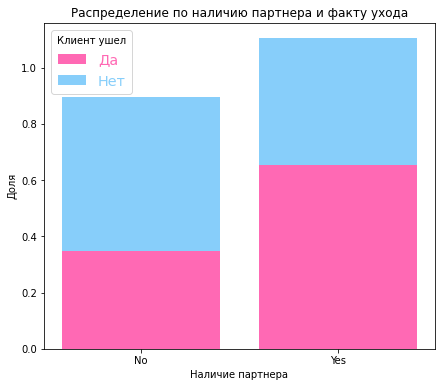

In [54]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('partner').size().reset_index(name='count')
stayed_counts = stayed.groupby('partner').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(7,6))
plt.bar(left_counts['partner'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['partner'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию партнера и факту ухода')
plt.xlabel('Наличие партнера')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper left', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

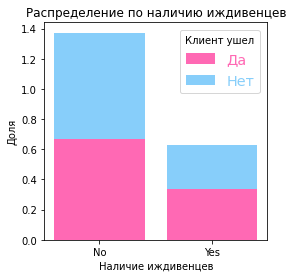

In [55]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('dependents').size().reset_index(name='count')
stayed_counts = stayed.groupby('dependents').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(4,4))
plt.bar(left_counts['dependents'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['dependents'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию иждивенцев')
plt.xlabel('Наличие иждивенцев')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

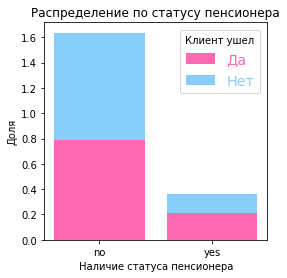

In [56]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('senior_citizen').size().reset_index(name='count')
stayed_counts = stayed.groupby('senior_citizen').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(4,4))
plt.bar(left_counts['senior_citizen'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['senior_citizen'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по статусу пенсионера')
plt.xlabel('Наличие статуса пенсионера')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

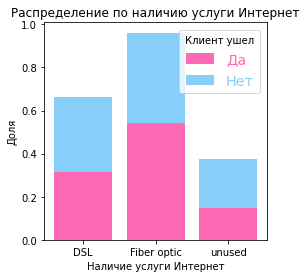

In [57]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('internet_service').size().reset_index(name='count')
stayed_counts = stayed.groupby('internet_service').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(4,4))
plt.bar(left_counts['internet_service'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['internet_service'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию услуги Интернет')
plt.xlabel('Наличие услуги Интернет')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

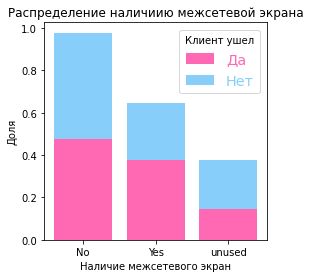

In [58]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('online_security').size().reset_index(name='count')
stayed_counts = stayed.groupby('online_security').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(4,4))
plt.bar(left_counts['online_security'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['online_security'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение наличиию межсетевой экрана')
plt.xlabel('Наличие межсетевого экран')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

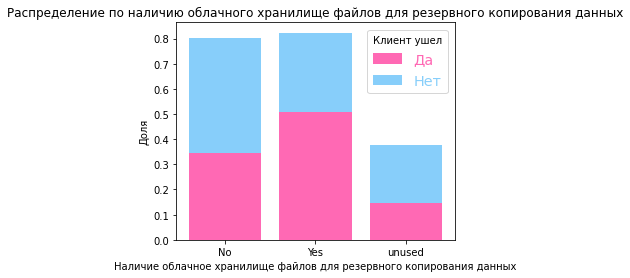

In [59]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('online_backup').size().reset_index(name='count')
stayed_counts = stayed.groupby('online_backup').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['online_backup'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['online_backup'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию облачного хранилище файлов для резервного копирования данных')
plt.xlabel('Наличие облачное хранилище файлов для резервного копирования данных')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

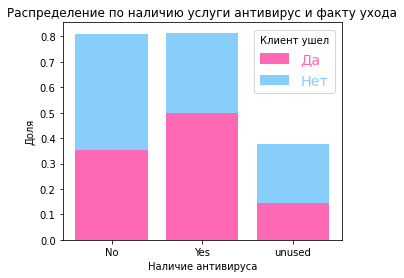

In [60]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('device_protection').size().reset_index(name='count')
stayed_counts = stayed.groupby('device_protection').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['device_protection'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['device_protection'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию услуги антивирус и факту ухода')
plt.xlabel('Наличие антивируса')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

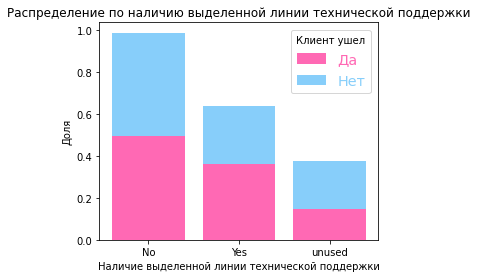

In [61]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('tech_support').size().reset_index(name='count')
stayed_counts = stayed.groupby('tech_support').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['tech_support'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['tech_support'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию выделенной линии технической поддержки')
plt.xlabel('Наличие выделенной линии технической поддержки')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

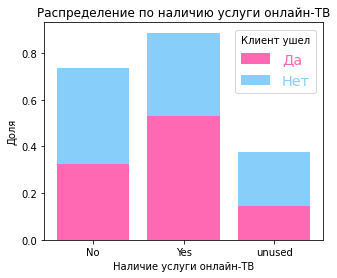

In [62]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('streaming_tv').size().reset_index(name='count')
stayed_counts = stayed.groupby('streaming_tv').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['streaming_tv'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['streaming_tv'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию услуги онлайн-ТВ')
plt.xlabel('Наличие услуги онлайн-ТВ')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

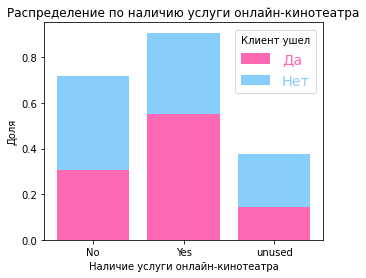

In [63]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('streaming_movies').size().reset_index(name='count')
stayed_counts = stayed.groupby('streaming_movies').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['streaming_movies'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['streaming_movies'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение по наличию услуги онлайн-кинотеатра')
plt.xlabel('Наличие услуги онлайн-кинотеатра')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

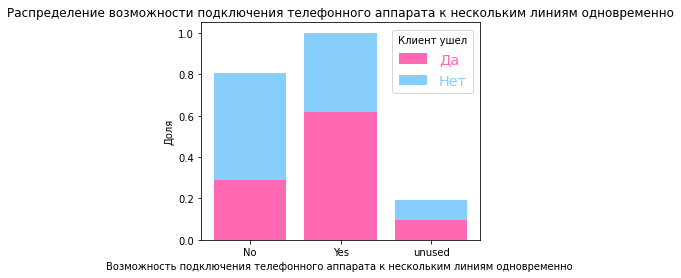

In [64]:
left = df[df['exited'] == 1]
stayed = df[df['exited'] == 0]

left_counts = left.groupby('multiple_lines').size().reset_index(name='count')
stayed_counts = stayed.groupby('multiple_lines').size().reset_index(name='count')

left_counts['share'] = left_counts['count'] / left_counts['count'].sum()
stayed_counts['share'] = stayed_counts['count'] / stayed_counts['count'].sum()

plt.figure(figsize=(5,4))
plt.bar(left_counts['multiple_lines'], left_counts['share'], color='#FF69B4')
plt.bar(stayed_counts['multiple_lines'], stayed_counts['share'], color='#87CEFA', bottom=left_counts['share'])
plt.title('Распределение возможности подключения телефонного аппарата к нескольким линиям одновременно')
plt.xlabel('Возможность подключения телефонного аппарата к нескольким линиям одновременно ')
plt.ylabel('Доля')
plt.legend(title='Клиент ушел', labels=['Да', 'Нет'], loc='upper right', fontsize='x-large', 
           labelcolor=['#FF69B4', '#87CEFA'])
plt.show()

Выводы по графикам: 
- Тип договора слабо влияет на факт ухода клиента.
- Клиенты, которые используют электронные счета чаще склонны к отказу от услуг. 
- Клиенты, использующие «mailed_check" - чек, отправленный по почте, реже других отказываются от услуг. 
- По полу распределение одинаковое.
- Статус пенсионного возраста слабо влияет на факт ухода клиента.
- Клиенты в браке чаще уходят из компании, чем холостые. 
- Пользователи без иждивенцев склонны к отказу услуг.
- Клиенты, использующие оптоволоконный интернет уходят чаще. Если клиент не пользуется интернетом, то вероятность отказа ниже.
- Пользователи, использующие услуги  резервного копирования данных, антивируса, онлайн-кинотеатра и онлай-ТВ чаще склонны к отказу от услуг, а пользователи, использующие услуги межсетевого экрана и выделенной линии технической поддержки менее склонны к уходу.
- Клиенты, использующие возможность подключения телефонного аппарата к нескольким линиям чаще других отказываются от услуг. 

Теперь посмотрим на мультиколлинеарность признаков. Для оценки связи между двумя различными по типу признаками можно использовать библиотеку phik.

In [65]:
num_cols = ['monthly_charges', 'total_charges', 'duration']

Стобцы begin_date, end_date т.к. мы сформировали новый столбец с периодом duration. Неинформативный столбец customer_id - тоже удалим. 

In [66]:
df = df.drop(['begin_date', 'end_date','customer_id'], axis = 1)
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,no,Yes,No,DSL,No,Yes,No,No,No,No,unused,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,no,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,no,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,no,No,No,DSL,Yes,No,Yes,Yes,No,No,unused,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,no,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


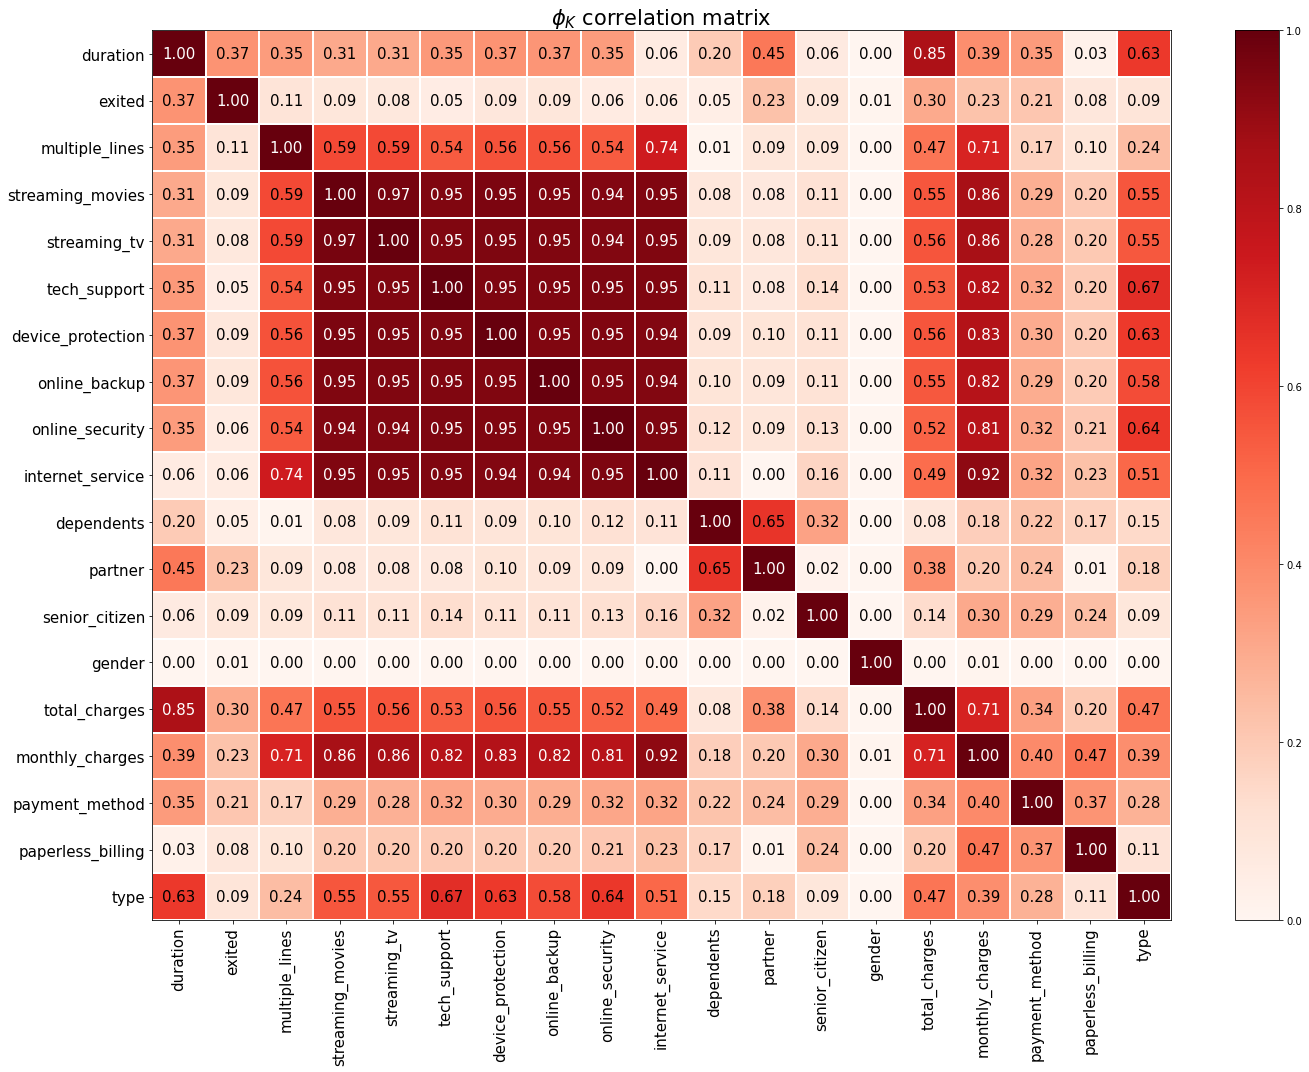

In [67]:
phik_matrix = df.phik_matrix(interval_cols=num_cols) 
phik_matrix.round(2)
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r'$\phi_K$ correlation matrix', 
                        fontsize_factor=1.5, 
                        figsize=(20, 15))
plt.tight_layout()

Высокая корреляция между столбцами: 
- total_charges и duration (0.85)
- monthly_charges и internet_service (0.92), соответственно со всеми услугами в пакете признак monthly_charges сильно коррелирует.
- чуть слабее между total_charges и monthly_charges (0.71)
- признак exited слабо коррелирует с остальными признаками, больше всего с признаком duration (0.37).

**Вывод:**

Мы объединили все таблицы по столбцу customerID, провели исследовательский анализ и предообратку датасета.

Выделили целевой признак в отдельный столбец - Exited на основе данных о контракте:
- если в столбце EndDate стоит дата ухода, то целевой признак равен 1 (ушел) 
- если в столбце EndDate стоит значение - "No", то значит клиент не ушел и целевой признак равен 0 (не ушел).

Переименовали названия столбцов - привели их к "змеиному стилю" и нижнему регистру. Обработали пропуски в столбцах, где это было необходимо. Изменили некорректный тип данных в некоторых столбцах. Посмотрели на распределение значений в целевой переменной exited - клиентов, которые прекратили пользоваться услугами намного меньше, чем тех, кто пользуется.

Провели визуализацию данных: 

Распределение численных признаков по факту ухода клиента: 

Выводы по графикам: 

- Суммарные траты на услуги - total_charges больше у оставшихся клиентов, то есть чем выше общие траты, тем дольше клиент остается. 
- В monthly_charges есть пик минимальной цены - наиболее популярна абонентская плата с наименьшей стоимостью, если расходы трат на ежемесячные услуги высокие - клиенты надолго не остаются.

Распределение категориальных признаков по факту ухода клиента. 
Выводы по графикам: 
- Тип договора слабо влияет на факт ухода клиента.
- Клиенты, которые используют электронные счета чаще склонны к отказу от услуг.
- Клиенты, использующие «mailed_check" - чек, отправленный по почте, реже других отказываются от услуг.
- По полу распределение одинаковое.
- Статус пенсионного возраста слабо влияет на факт ухода клиента.
- Клиенты в браке чаще уходят, чем холостые.
- Пользователи без иждивенцев склонны к отказу услуг.
- Клиенты, использующие оптоволоконный интернет уходят чаще. Если клиент не пользуется интернетом, то вероятность отказа ниже.
- Пользователи, использующие услуги резервного копирования данных, антивируса, онлайн-кинотеатра и онлай-ТВ чаще склонны к отказу от услуг, а пользователи, использующие услуги межсетевого экрана и выделенной линии технической поддержки менее склонны к уходу.
- Клиенты, использующие возможность подключения телефонного аппарата к нескольким линиям чаще других отказываются от услуг.

Посмотрели на мультиколлинеарность признаков: 

Высокая корреляция между столбцами:

- total_charges и duration (0.85)
- monthly_charges и internet_service (0.92), соответственно со всеми услугами в пакете признак monthly_charges сильно коррелирует.
- чуть слабее между total_charges и monthly_charges (0.71)
- признак exited слабо коррелирует с остальными признаками, больше всего с признаком duration (0.37).

Признаки begin_date, end_date, customer_id - непригодны для обучения моделей, поэтому мы их удалили.Так же можно удалить столбец total_charges так как у нас есть столбцы с ежемесячной выручкой и периодом использования клиентом услуг и неинформативный столбец gender.

# 5. Подготовка данных к обучению:


Удалим столбец total_charges, так как у нас есть столбцы с ежемесячной вырочкой и периодом использования клиентом услуг. Так же удалим неиформативный столбец gender, который слабо коррелирует с целевым признаком.

In [68]:
df = df.drop(['total_charges','gender'], axis = 1)
df.head()

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,duration
0,Month-to-month,Yes,Electronic check,29.85,no,Yes,No,DSL,No,Yes,No,No,No,No,unused,0,31
1,One year,No,Mailed check,56.95,no,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,no,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,no,No,No,DSL,Yes,No,Yes,Yes,No,No,unused,0,1371
4,Month-to-month,Yes,Electronic check,70.70,no,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Разобьём данные на тренировочную и тестовую выборки в соотношении 3 к 1.

In [69]:
target = df['exited']
features = df.drop('exited', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify = target) 
print(features_train.shape)
print(features_test.shape)

(5282, 16)
(1761, 16)


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   senior_citizen     7043 non-null   object 
 5   partner            7043 non-null   object 
 6   dependents         7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  multiple_lines     7043 non-null   object 
 15  exited             7043 non-null   int64  
 16  duration           7043 

Наши данные содержат категориальные признаки. Преобразуем категориальные признаки для линейных моделей в численные техникой прямого кодирования, или отображения (англ. One-Hot Encoding, OHE). 

Техникой OHE категориальные признаки переводятся в численные в два этапа:
- Для каждого значения признака создаётся новый столбец;
- Если объекту категория подходит, присваивается 1, если нет — 0.

In [71]:
# Выберем категориальные признаки для кодирования
cat_features = [i for i in features_train.columns if features_train[i].dtype in ['object']]
print(cat_features)

['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [72]:
# Выберем численные признаки для кодирования
num_features = [i for i in features_train.columns if features_train[i].dtype in ['float64', 'int64']]
print(num_features)

['monthly_charges', 'duration']


In [73]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [74]:
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(5282, 16)
(1761, 16)


In [75]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[cat_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names() позволяет получить названия колонок
features_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohe[cat_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(cat_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])

# смотрим на результат
features_train_ohe.head()

,monthly_charges,duration,x0_Month-to-month,x0_One year,x0_Two year,x1_No,x1_Yes,x2_Bank transfer (automatic),x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_no,x3_yes,x4_No,x4_Yes,x5_No,x5_Yes,x6_DSL,x6_Fiber optic,x6_unused,x7_No,x7_Yes,x7_unused,x8_No,x8_Yes,x8_unused,x9_No,x9_Yes,x9_unused,x10_No,x10_Yes,x10_unused,x11_No,x11_Yes,x11_unused,x12_No,x12_Yes,x12_unused,x13_No,x13_Yes,x13_unused
4432,-0.806410,0.312375,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2035,-0.029485,0.579626,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
750,-0.270199,-0.129169,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2213,-1.314399,-0.792938,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6771,-1.467127,0.049482,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [76]:
# энкодером, который обучен на тренировочной выборке, кодируем тестовую
features_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohe[cat_features])

features_test_ohe = features_test_ohe.drop(cat_features, axis=1)

# скелером, который обучен на тренировочной выборке, масштабируем тестовую
features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

# смотрим на результат
features_test_ohe.head()

,monthly_charges,duration,x0_Month-to-month,x0_One year,x0_Two year,x1_No,x1_Yes,x2_Bank transfer (automatic),x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_no,x3_yes,x4_No,x4_Yes,x5_No,x5_Yes,x6_DSL,x6_Fiber optic,x6_unused,x7_No,x7_Yes,x7_unused,x8_No,x8_Yes,x8_unused,x9_No,x9_Yes,x9_unused,x10_No,x10_Yes,x10_unused,x11_No,x11_Yes,x11_unused,x12_No,x12_Yes,x12_unused,x13_No,x13_Yes,x13_unused
1045,1.144201,0.357401,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
857,-0.466090,-1.189457,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
859,-0.001264,1.859233,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
647,0.159765,0.003004,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5342,-0.002924,-0.485019,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Категориальные признаки перевели в численные через One-Hot Encoding, количественные нормировали через StandardScaler

# 6.Обучение и контроль качества модели машинного обучения:


Напишем функцию, которая принимает на вход модель и параметры для ее настройки, ообучает с использованием кросс-валидации, выбирает лучшую модель и выводит на экран лучшие параметры, значение метрики и лучшую модель. 

In [77]:
def model_grid(model, params, features_train, target_train):
    grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(features_train, target_train)
    print('ROC-AUC:', round(grid_search.best_score_, 3))
    print(f'Best params: {grid_search.best_params_}')
    print(f'Best model: {grid_search.best_estimator_}')
    return grid_search.best_estimator_

Напишем функцию, которая дает оценки на тестовой выборке.

In [78]:
def metric(model, features_test, target_test):
    predict = model.predict(features_test)
    predict_test = model.predict_proba(features_test)
    probabilities_test = predict_test[:, 1]
    print('Accuracy: {:.3f}'.format(accuracy_score(target_test, predict)))
    print('Recall(Полнота): {:.3f}'.format(recall_score(target_test, predict)))
    print('Precision(Точность): {:.3f}'.format(precision_score(target_test, predict)))
    print('ROC-AUC: {:.3f}'.format(roc_auc_score(target_test, probabilities_test)))

Напишем функцию, которая выводит ROC-кривую.

In [79]:
def figure_roc_auc(model, features_test):
    predict_test = model.predict_proba(features_test)
    probabilities_test = predict_test[:, 1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

Напишем функцию, которая выводит матрицу ошибок.

In [80]:
def matrix(model, features_test, target_test):  
    predict = model.predict(features_test)
    disp = ConfusionMatrixDisplay(confusion_matrix(target_test, predict))
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax)   
    plt.xlabel('Предсказания')
    plt.ylabel('Ответы')
    plt.title('Матрица ошибок')
    plt.show()

<div class="alert alert-block alert-success">
✔️ <b>Ревью 4</b>: Функции очень удобные. Молодец!
</div>

**Модель логистическая регрессия - LogisticRegression**

In [81]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)
param_grid_lr = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver' :['saga','liblinear', 'lbfgs']
}
best_lr = model_grid(model_lr, param_grid_lr, features_train_ohe, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
ROC-AUC: 0.754
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best model: LogisticRegression(C=0.1, random_state=28082023, solver='liblinear')


Выводы: 
- Гиперпараметры лучшей модели - {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
- ROC-AUC: 0.754

**Модель случайный лес - RandomForestClassifier**

In [82]:
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

In [83]:
# Выберем категориальные признаки для кодирования
categorical_columns_oe = features_train_oe.select_dtypes(include='object').columns.to_list()
categorical_columns_oe

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [84]:
# Выберем численные признаки для кодирования
num_columns_oe = features_train_oe.select_dtypes(exclude='object').columns.to_list()
num_columns_oe

['monthly_charges', 'duration']

In [85]:
# закодируем признаки с помощью порядкового кодирования
ordinal_encoder = OrdinalEncoder()

features_train_oe[categorical_columns_oe] = ordinal_encoder.fit_transform(features_train_oe[categorical_columns_oe])

features_test_oe[categorical_columns_oe] = ordinal_encoder.transform(features_test_oe[categorical_columns_oe])

In [86]:
scaler = StandardScaler()

features_train_oe[num_columns_oe] = scaler.fit_transform(features_train_oe[num_columns_oe])
features_test_oe[num_columns_oe] = scaler.transform(features_test_oe[num_columns_oe])

print(features_train_oe.shape)
print(features_test_oe.shape)

(5282, 16)
(1761, 16)


In [87]:
%%time
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
param_grid_rfc = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
best_rfc = model_grid(model_rfc, param_grid_rfc, features_train_oe, target_train)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
ROC-AUC: 0.832
Best params: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50}
Best model: RandomForestClassifier(max_depth=9, min_samples_split=8, n_estimators=50,
                       random_state=28082023)
CPU times: user 6min 32s, sys: 4.35 s, total: 6min 37s
Wall time: 6min 38s


Выводы: 
- Гиперпараметры лучшей модели случайного леса  - 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50
- ROC-AUC: 0.832

**Модель LGBMClassifier**

Для модели LGBM переведем категориальные переменные в тип данных category. Воспользуемся встроенными собственными внутренними механизмами кодирования категориальных переменных.

In [88]:
features_train_cat = features_train.copy()
features_test_cat = features_test.copy()

In [89]:
# Выберем категориальные признаки для кодирования
categorical_columns = features_train_cat.select_dtypes(include='object').columns.to_list()
categorical_columns

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [90]:
# Выберем численные признаки для кодирования
numerical_columns = features_train_cat.select_dtypes(exclude='object').columns.to_list()
numerical_columns

['monthly_charges', 'duration']

In [91]:
features_train_cat[categorical_columns] = features_train_cat[categorical_columns].astype('category')
features_test_cat[categorical_columns] = features_test_cat[categorical_columns].astype('category')

In [92]:
print(features_train_cat.shape)
print(features_test_cat.shape)

(5282, 16)
(1761, 16)


In [93]:
%%time
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
param_grid_lgbm  = {'n_estimators': [100, 300, 500],
                      'learning_rate': [0.01, 0.1, 1],
                      'max_depth': [x for x in range(1,6)]}
best_lgbm = model_grid(model_lgbm, param_grid_lgbm, features_train_cat, target_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
ROC-AUC: 0.909
Best params: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 300}
Best model: LGBMClassifier(learning_rate=1, max_depth=2, n_estimators=300,
               random_state=28082023)
CPU times: user 8min 21s, sys: 3.1 s, total: 8min 24s
Wall time: 8min 28s


Выводы: 
- Гиперпараметры лучшей модели LGBMClassifier - {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 300}
- ROC-AUC: 0.909

Модель LGBMClassifier показала наилучший результат значения ROC-AUC: 0.909. Проверим ее на тестовой выборке.

Accuracy: 0.930
Recall(Полнота): 0.625
Precision(Точность): 0.896
ROC-AUC: 0.923


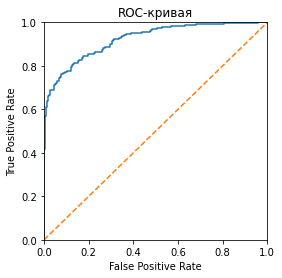

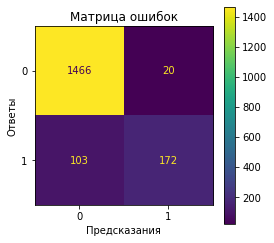

In [94]:
metric(best_lgbm, features_test_cat, target_test)
figure_roc_auc(best_lgbm, features_test_cat)
matrix(best_lgbm, features_test_cat, target_test)

Выводы: 
- Accuracy: 0.930
- Recall(Полнота): 0.625
- Precision(Точность): 0.896
- ROC-AUC: 0.923
- Количество верно предсказанных фактов ухода клиента - 1638
- Количество неверно предсказанных фактов ухода клиента - 123

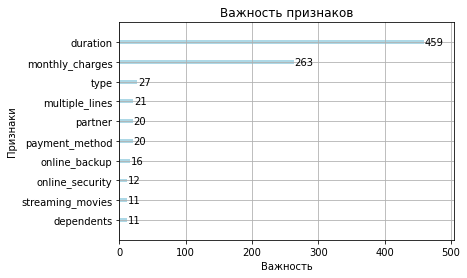

In [95]:
feature_importances = best_lgbm.feature_importances_
lightgbm.plot_importance(best_lgbm, max_num_features=10, importance_type='split', color='lightblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

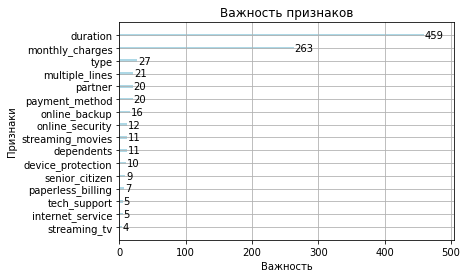

In [96]:
# код тимлида для проверки важности признаков по просьбе клиентов senior_citizen (обращение приложено выше)
feature_importances = best_lgbm.feature_importances_
lightgbm.plot_importance(best_lgbm, importance_type='split', color='lightblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

Описание выводов: 

- Метрика Accuracy (точность) = 0.93, означает, что модель правильно классифицировала 93% объекта.
- Метрика ROC_AUC = 0.923 означает, что модель с высокой вероятностью предскажет уход клиентов.
- Полнота Recall = 0.625 показывает сколько истинных ответов было предсказано. Модель правильно определила 62.5% объектов положительного класса.
- Точность Precision = 0.896 означает, что 89.6% ответов являются положительными. Остальные - ложно-положительные false positives.
- ROC-кривая - это график, который отображает зависимость между доля истинно положительных ответов. True Positive Rate (TPR) - по вертикали и долей ложноположительных ответов False Positive Rate (FPR) по горизонтали. Чем ближе ROC-кривая к верхнему левому углу графика, тем лучше качество модели. График показывает высокое качество модели.  

Матрица ошибок: 

- False Positive = 20 - модель совершила 20 ошибок первого рода, это значит предсказала уход клиентов, которого не было.
- False Negative = 103 - модель совершила 103 ошибки второго рода и не заметила уход 103 клиентов, которые на самом деле ушли.
- True Positive = 1466 - модель правильно предсказала 1466 ответов, прогноз совпал с реальностью.
- True Negative = 172 - модель правильно предсказала 103 ответа, отнесенных к отрицательному классу.

Важные признаки - duration, monthly_charges. Это означает, что продолжительность контракта в днях и месячная сумма оплаты являются наиболее важными признаками для прогнозирования оттока клиентов. Эту информацию можно использовать для улучшения стратегии удержания клиентов и увеличения их лояльности.

**Вывод:**

Мы отобрали наиболее важные признаки для прогнозирования оттока клиентов. Добавили новый признак duration - период пользования услугами клиентами в днях.  

Разбили данные на обучающую и тестовую выборки в соотношении - 3 к 1. Закодировали признаки с помощью One-Hot Encoding для линейных моделей, для деревянных с помощью OrdinalEncoder. Для модели LGBMClassifier воспользовались встроенными собственными внутренними механизмами кодирования категориальных переменных.

Обучили следующие модели: LogisticRegression, RandomForestClassifier, LGBMClassifier. Подобрали гиперпараметры и оценили качество моделей кросс-валидацией с использованием основной метрики ROC-AUC.

Модель LightGBM показала наилучший результат значения ROC-AUC: 0.909.


На тестовой выборке модель LightGBM показала следующие результаты: 
- Accuracy: 0.930
- Recall(Полнота): 0.625
- Precision(Точность): 0.896
- ROC-AUC: 0.923
- Метрика Accuracy (точность) = 0.93, означает, что модель правильно классифицировала 93% объекта.
- Метрика ROC_AUC = 0.923 — означает, что модель с высокой вероятностью предскажет уход клиентов.
- Полнота Recall = 0.625 показывает сколько истинных ответов было предсказано. Модель правильно определила 62.5% объектов положительного класса.
- Точность Precision = 0.896 означает, что 89.6% ответов являются положительными. Остальные - ложно-положительные false positives.
- ROC-кривая - это график, который отображает зависимость между доля истинно положительных ответов True Positive Rate (TPR) - по вертикали и долей ложноположительных ответов False Positive Rate (FPR) по горизонтали. Чем ближе ROC-кривая к верхнему левому углу графика, тем лучше качество модели. График показывает высокое качество модели.  

Матрица ошибок: 

- False Positive = 20 - модель совершила 20 ошибок первого рода, это значит, что она предсказала уход клиентов, которого не было.
- False Negative = 103 - модель совершила 103 ошибки второго рода и не заметила уход 103 клиентов, которые на самом деле ушли.
- True Positive = 1466 - модель правильно предсказала 1466 ответов, прогноз совпал с реальностью.
- True Negative = 172 - модель правильно предсказала 103 ответа, отнесенных к отрицательному классу.

Так же мы оценили важность признаков лучше модели: 

- Важные признаки - duration, monthly_charges. 

Это означает, что продолжительность контракта в днях и месячная сумма оплаты являются наиболее важными признаками для прогнозирования оттока клиентов. Эту информацию можно использовать для улучшения стратегии удержания клиентов и увеличения их лояльности.

# 7. Анализ результатов и общий вывод.

Таким образом, мы изучили данные о некоторых клиентах и информацию об их тарифах и договорах оператора связи «Ниединогоразрыва.ком», который хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

В проекте была проделана следующая работа:

Проведен первичный анализ данных: 

- Клиенты чаще выбирают тип договора - ежемесячный (55%), так же предпочитают получать электронный счет по почте (59,2%) и оплачивать его с помощью электронного чека (33,6%).
- В данных клиенты по полу распределены практически равномерно - male (50,5%) и female(49,5%), Холостых клиентов чуть больше (51,7%), чем с партнерами(супругом/супругой) - 48,3%. Пожилые люди практически не пользуются услугами интернета и телефонной связи (16,2%). Клиентов с иждивенцеми значительно меньше (70%), чем с их наличием (30%).
- По подключению услуги Интернет лидирует оптоволоконный кабель(56,1%).
- От дополнительных услуг пользователи чаще отказываются, а услугами онлайн-кинотеатра(50,5%) и онлайн-ТВ (49,5%) клиенты пользуются практически одинаково.
- По услуге возможности подключения телефона к нескольким линиям одновременно перевес в сторону тех, кто ее не использует (53,3%).

Мы объединили все таблицы по столбцу customerID, провели исследовательский анализ и предообратку датасета. 

Выделили целевой признак в отдельный столбец - Exited на основе данных о контракте: если в столбце EndDate стоит дата ухода, то целевой признак равен 1 (ушел), если в столбце EndDate стоит значение - "No", то значит клиент не ушел и целевой признак равен 0 (не ушел).  Изменили названия столбцов, для удобства работы привели их к змеиному регистру. Обработали пропуски в столбцах, где это было необходимо. Изменили некорректный тип данных в некоторых столбцах. Посмотрели на распределение значений в целевой переменной exited - клиентов, которые прекратили пользоваться услугами намного меньше, чем тех, кто пользуется.

Провели визуализацию данных. Получили следующие результаты: 

- Суммарные траты на услуги - total_charges больше у оставшихся клиентов, то есть чем выше общие траты, тем дольше клиент остается.
- В monthly_charges есть пик минимальной цены - наиболее популярна абонентская плата с наименьшей стоимостью, если расходы трат на ежемесячные услуги высокие - клиенты надолго не остаются.
- Тип договора слабо влияет на факт ухода клиента.
- Клиенты, которые используют электронные счета чаще склонны к отказу от услуг.
- Клиенты, использующие «mailed_check" - чек, отправленный по почте, реже других отказываются от услуг.
- По полу распределение одинаковое.
- Статус пенсионного возраста слабо влияет на факт ухода клиента.
- Клиенты в браке чаще уходят, чем холостые.
- Пользователи без иждивенцев склонны к отказу услуг.
- Клиенты, использующие оптоволоконный интернет уходят чаще. Если клиент не пользуется интернетом, то вероятность отказа ниже.
- Пользователи, использующие услуги резервного копирования данных, антивируса, онлайн-кинотеатра и онлай-ТВ чаще склонны к отказу от услуг, а пользователи, использующие услуги межсетевого экрана и выделенной линии технической поддержки менее склонны к уходу.
- Клиенты, использующие возможность подключения телефонного аппарата к нескольким линиям чаще других отказываются от услуг.


Посмотрели на мультиколлинеарность признаков:

Высокая корреляция между столбцами:

- total_charges и duration (0.85)
- monthly_charges и internet_service (0.92), соответственно со всеми услугами в пакете признак monthly_charges сильно коррелирует.
-  признак exited слабо коррелирует с остальными признаками, больше всего с признаком duration (0.37).
Мы отобрали наиболее важные признаки для прогнозирования оттока клиентов - признаки begin_date, end_date, customer_id, gender, total_charges - непригодны и неинформативны для обучения моделей, поэтому мы их удалили. Добавили новый признак duration - период пользования услугами клиентами в днях.

Разбили данные на обучающую и тестовую выборки в соотношении - 3 к 1. Закодировали признаки с помощью One-Hot Encoding для линейных моделей, для деревянных с помощью OrdinalEncoder. Для модели LGBMClassifier воспользовались встроенными собственными внутренними механизмами кодирования категориальных переменных.

Обучили следующие модели: LogisticRegression, RandomForestClassifier, LGBMClassifier. Подобрали гиперпараметры и оценили качество моделей кросс-валидацией с использованием основной метрики ROC-AUC.

Модель LGBMClassifier показала наилучший результат значения ROC-AUC: 0.909.Метрика ROC_AUC = 0.923 — это значит, что модель с высокой вероятностью предскажет уход клиентов.

На тестовой выборке модель LGBMClassifier показала следующие результаты:
- ROC-AUC: 0.923. Метрика ROC_AUC показывает, что модель с высокой вероятностью предскажет уход клиентов.
- Accuracy: 0.930. Метрика Accuracy означает, что модель правильно классифицировала 93% объекта.
- Recall(Полнота): 0.625. Полнота  показывает сколько истинных ответов было предсказано. Модель правильно определила 62.5% объектов положительного класса.
- Precision(Точность): 0.896. Точность означает, что 89.6% ответов являются положительными. Остальные - ложно-положительные false positives.
- ROC-кривая - это график, который отображает зависимость между доля истинно положительных ответов True Positive Rate (TPR) - по вертикали и долей ложноположительных ответов False Positive Rate (FPR) по горизонтали. Чем ближе ROC-кривая к верхнему левому углу графика, тем лучше качество модели. График показывает высокое качество модели.

Так же мы рассмотрели матрицу ошибок наилучшей модели и получили следующие результаты: 

- False Positive = 20 - модель совершила 20 ошибок первого рода, это значит, что она предсказала уход клиентов, которого не было.
- False Negative = 103 - модель совершила 103 ошибки второго рода и не заметила уход 103 клиентов, которые на самом деле ушли.
- True Positive = 1466 - модель правильно предсказала 1466 ответов, прогноз совпал с реальностью.
- True Negative = 172 - модель правильно предсказала 103 ответа, отнесенных к отрицательному классу.

Оценка важности признаков лучше модели:

- Важные признаки - duration, monthly_charges. Это означает, что продолжительность контракта в днях и месячная сумма оплаты являются наиболее важными признаками для прогнозирования оттока клиентов. Эту информацию можно использовать для улучшения стратегии удержания клиентов и увеличения их лояльности.